<h1> Loading the Data </h1>

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#PS: Pressure, bar, 100 Hz --> 100 Messungen pro Sekunde
#EPS: Motor power, W, 100 Hz 
#FS: Volume flow, l/min, 10 Hz --> 10 Messungen pro Sekunde
#TS: Temperature, Celsius, 1 Hz --> 1 Messung pro Sekunde
#VS: Vibration, mm/s, 1Hz
#CE: Cooling efficiency (virtual), %, 1 Hz
#CP: Cooling power (virtual), kW, 1 Hz
#SE: Efficency factor, %, 1 Hz


class DataProcessor:
    def __init__(self, input_path, file_names):
        self.input_path = input_path
        self.file_names = file_names
        
    def read_files(self):
        self.data = {}
        print("Reading files...")
        for file in self.file_names:
            with open(self.input_path + file + '.txt', 'r') as f:
                self.data[file] = pd.read_csv(f, header=None, sep='\t')
        return self.data
    
    def print_shape(self):
        print("Files read:")
        for file in self.data:
            print(f"{file}: {self.data[file].shape}")
            
    def create_target_df(self):
        target_columns = ['Cooler_Condition', 'Valve_Condition', 
                        'Internal_Pump_Leakage', 'Hydraulic_Accumulator', 
                        'Stable_Flag']
        self.data['target'].columns = target_columns
        self.valve_condition = self.data['target']['Valve_Condition']
        #del self.data['target']
        return self.valve_condition

def process_data():
    input_path = "input_data/"
    file_names = [
        "ce", "cp", "eps1", "se", "vs1", 
        "fs1", "fs2", 
        "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
        "ts1", "ts2", "ts3", "ts4", "target"
    ]
    
    processor = DataProcessor(input_path, file_names)
    data = processor.read_files()
    processor.print_shape()
    df_target = processor.create_target_df()
    df_target = processor.valve_condition
    return data, df_target

data, df_target = process_data()

Reading files...
Files read:
ce: (2205, 60)
cp: (2205, 60)
eps1: (2205, 6000)
se: (2205, 60)
vs1: (2205, 60)
fs1: (2205, 600)
fs2: (2205, 600)
ps1: (2205, 6000)
ps2: (2205, 6000)
ps3: (2205, 6000)
ps4: (2205, 6000)
ps5: (2205, 6000)
ps6: (2205, 6000)
ts1: (2205, 60)
ts2: (2205, 60)
ts3: (2205, 60)
ts4: (2205, 60)
target: (2205, 5)


<h1> 1. Data Exploration </h1>

<h2>CE sensor (1 Hz) </h2>

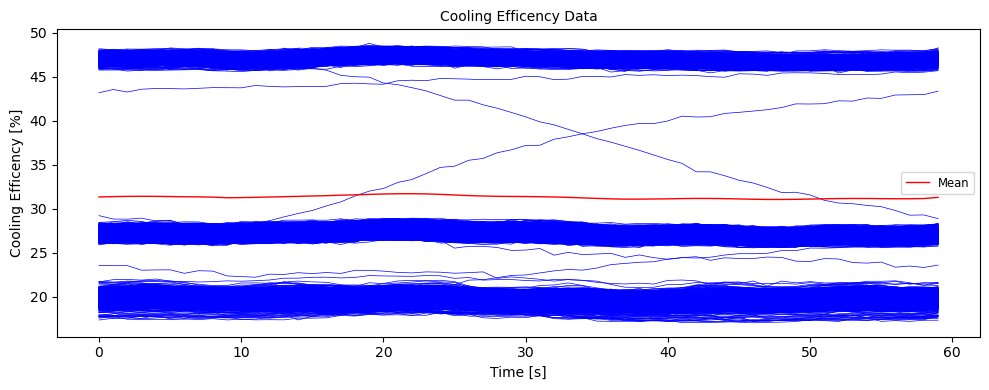

In [70]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['ce'].shape[0] - 1):
    ax.plot(data['ce'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['ce'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Cooling Efficency Data', fontsize=10)
plt.xlabel("Time [s]")
plt.ylabel("Cooling Efficency [%]")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

In [80]:
df_combined = pd.concat([data['ce'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     31.319484
80     31.297182
90     31.358514
100    31.274134
dtype: float64


<h2>CP Sensor (1 Hz)</h2>

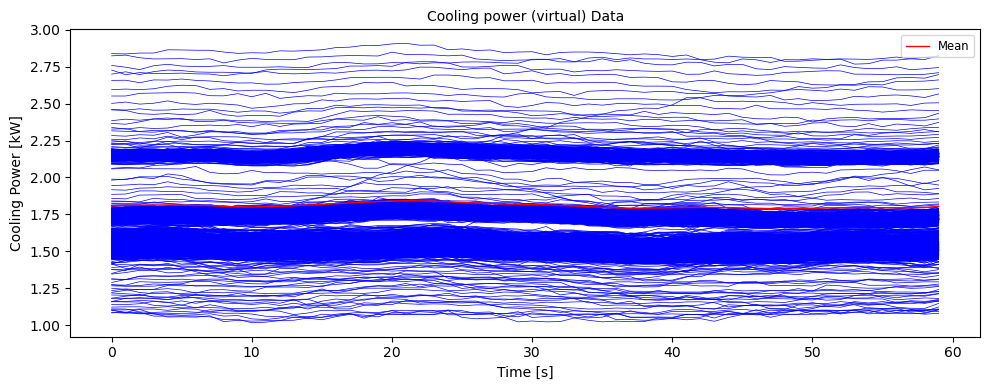

In [71]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['cp'].shape[0] - 1):
    ax.plot(data['cp'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['cp'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Cooling power (virtual) Data', fontsize=10)
plt.xlabel("Time [s]")
plt.ylabel("Cooling Power [kW]")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

In [81]:
df_combined = pd.concat([data['cp'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     1.805034
80     1.805221
90     1.808178
100    1.810562
dtype: float64


<h2>VS Sensor (1 Hz)</h2>

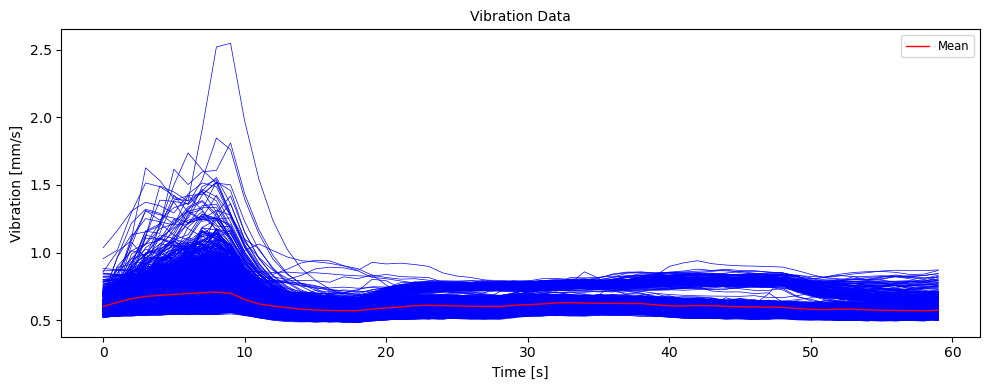

In [72]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['vs1'].shape[0] - 1):
    ax.plot(data['vs1'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['vs1'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Vibration Data', fontsize=10)
plt.xlabel("Time [s]")
plt.ylabel("Vibration [mm/s]")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

In [82]:
df_combined = pd.concat([data['vs1'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     0.623013
80     0.619320
90     0.616718
100    0.607202
dtype: float64


In [ ]:
#Ausreiser entfernen
remove_row = data['vs1'][np.any(data['vs1'].values > 2.0, axis=1)]
data['vs1'] = data['vs1'].drop(remove_row.index)

<h2>SE Sensor (1 Hz)</h2>

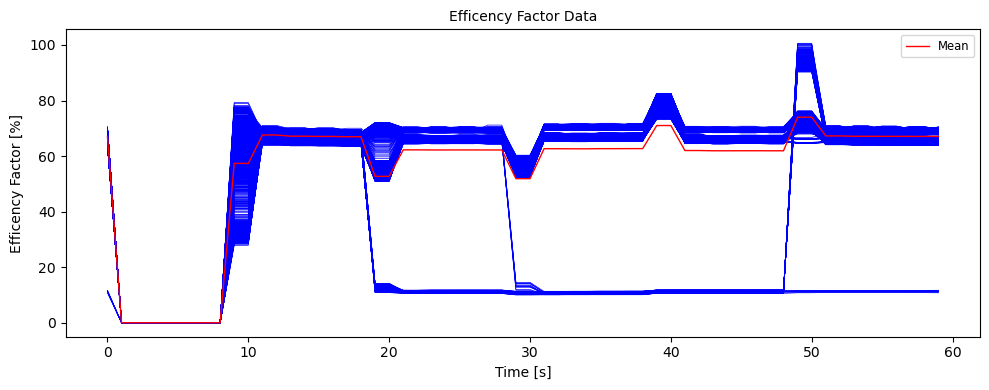

In [83]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

for i in range(data['se'].shape[0] - 1):
    ax.plot(data['se'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['se'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Efficency Factor Data', fontsize=10)
plt.xlabel("Time [s]")
plt.ylabel("Efficency Factor [%]")
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

In [84]:
df_combined = pd.concat([data['se'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     52.441894
80     53.263315
90     53.464748
100    57.429897
dtype: float64


<h2>TS Sensors (1 Hz)</h2>

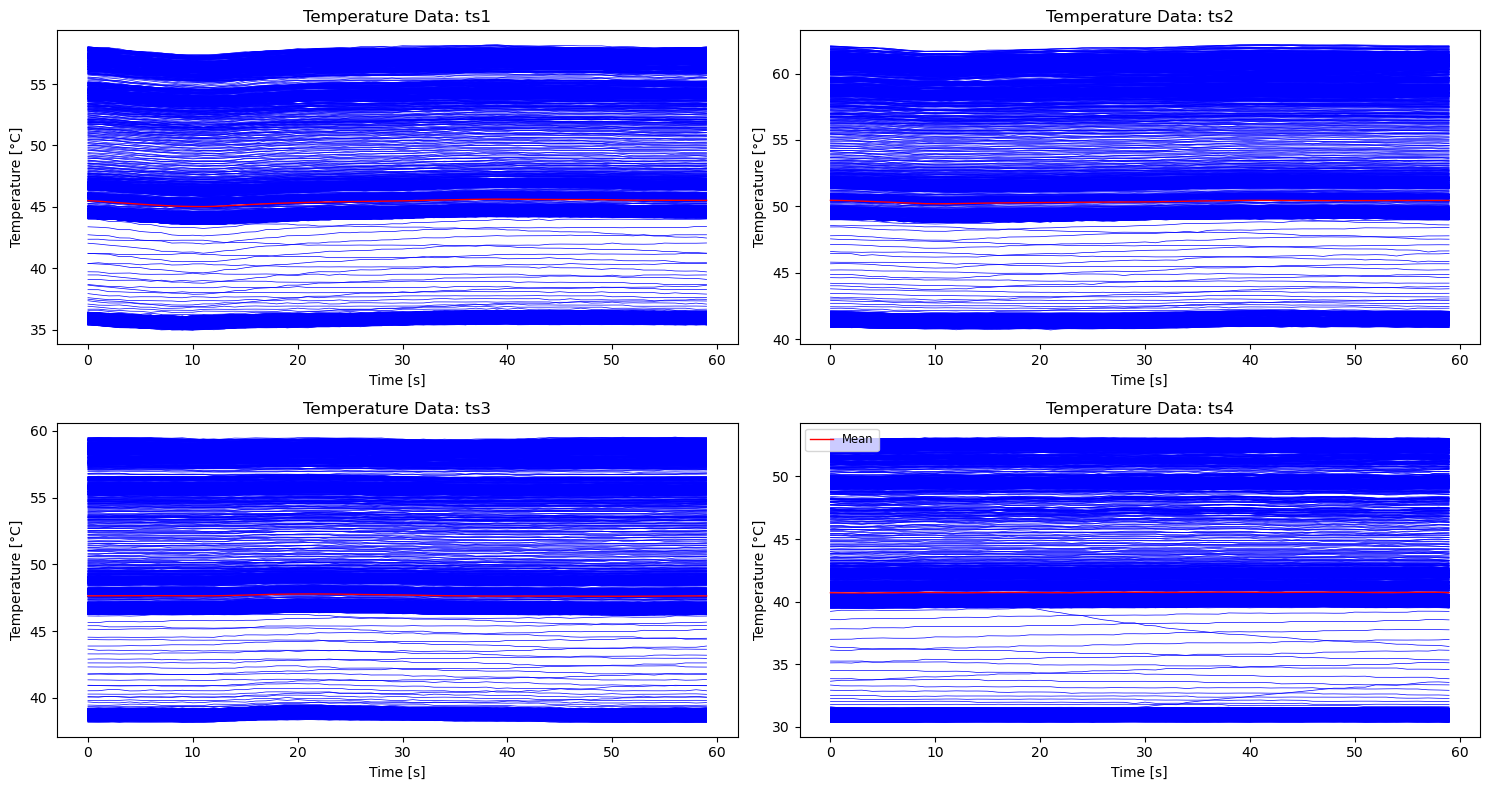

In [74]:
temp_sensors = ['ts1', 'ts2', 'ts3', 'ts4']

fig, axes = plt.subplots(2, 2, figsize=(15, 8), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(temp_sensors):
    ax = axes[idx]
    for i in range(data[s].shape[0] - 1):
        ax.plot(data[s].iloc[i], color='blue', linewidth=0.5)
    ax.plot(data[s].mean(axis=0), color='red', linewidth=1, label = 'Mean')
    
    ax.set_title(f"Temperature Data: {s}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Temperature [°C]")
    
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

In [65]:
for s in temp_sensors:
    df_combined = pd.concat([data[s], df_target], axis=1)
    mean_per_condition = (
        df_combined.drop(columns=['Valve_Condition'], axis=1) 
          .groupby(df_combined['Valve_Condition'])           
          .mean()                                
          .mean(axis=1)
        )
    print(s + ':')                             
    print(mean_per_condition)

ts1:
Valve_Condition
73     45.629744
80     45.647847
90     45.671871
100    45.208323
dtype: float64
ts2:
Valve_Condition
73     50.500104
80     50.512613
90     50.525565
100    50.225068
dtype: float64
ts3:
Valve_Condition
73     47.857446
80     47.880050
90     47.901773
100    47.453192
dtype: float64
ts4:
Valve_Condition
73     40.933590
80     40.954339
90     40.961833
100    40.529958
dtype: float64


<h2>FS Sensors (10 Hz)</h2>

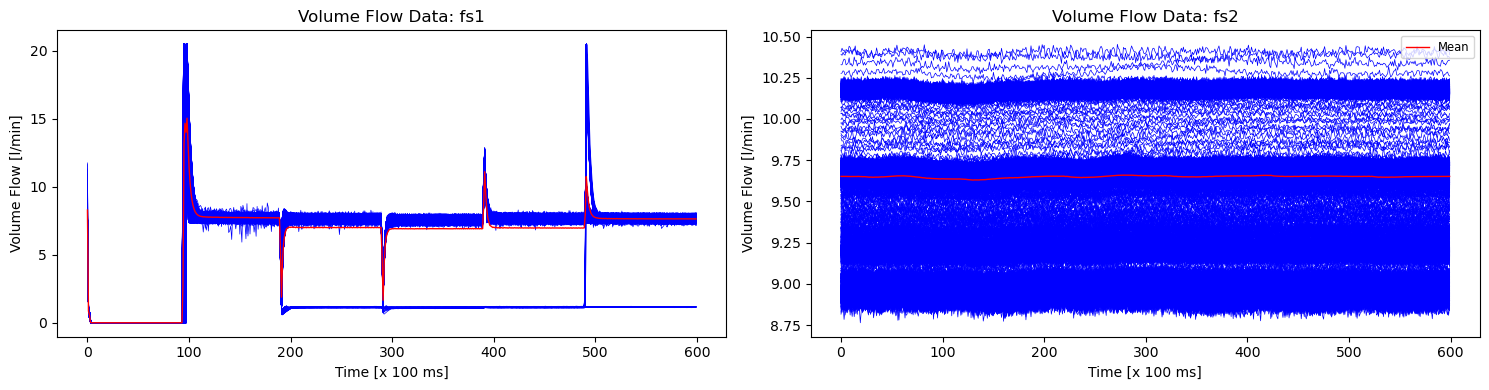

In [75]:
vf_sensors = ['fs1', 'fs2']

fig, axes = plt.subplots(1, 2, figsize=(15, 4), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(vf_sensors):
    ax = axes[idx]
    for i in range(data[s].shape[0] - 1):
        ax.plot(data[s].iloc[i], color='blue', linewidth=0.5)
    ax.plot(data[s].mean(axis=0), color='red', linewidth=1, label='Mean')
    
    ax.set_title(f"Volume Flow Data: {s}")
    ax.set_xlabel("Time [x 100 ms]")
    ax.set_ylabel("Volume Flow [l/min]")
    
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

In [89]:
for s in vf_sensors:
    df_combined = pd.concat([data[s], df_target], axis=1)
    mean_per_condition = (
        df_combined.drop(columns=['Valve_Condition'], axis=1) 
          .groupby(df_combined['Valve_Condition'])           
          .mean()                                
          .mean(axis=1)
        )
    print(s + ':')                             
    print(mean_per_condition)

fs1:
Valve_Condition
73     5.951552
80     5.993925
90     5.990347
100    6.409693
dtype: float64
fs2:
Valve_Condition
73     9.631467
80     9.628707
90     9.625955
100    9.669367
dtype: float64


<h2>EPS Sensor (100 Hz)</h2>

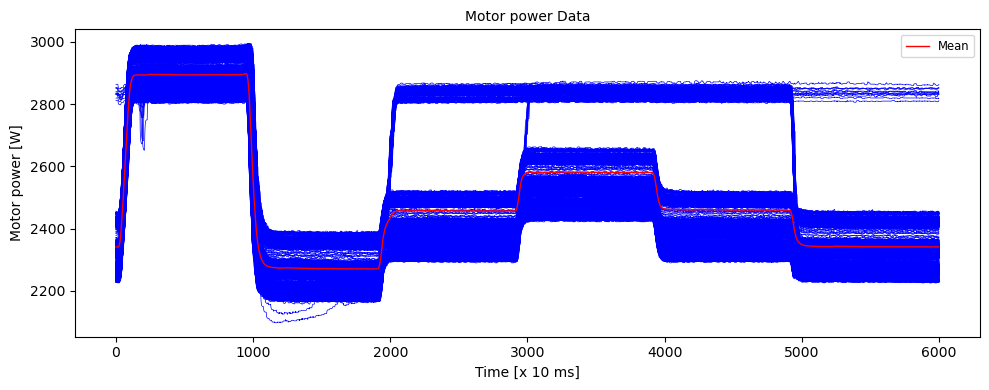

In [76]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
for i in range(data['eps1'].shape[0] - 1):
    ax.plot(data['eps1'].iloc[i], color='blue', linewidth=0.5)

ax.plot(data['eps1'].mean(axis=0), color='red', linewidth=1, label='Mean')

ax.set_title('Motor power Data', fontsize=10)
plt.xlabel("Time [x 10 ms]")
plt.ylabel("Motor power [W]")
plt.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()

In [67]:
df_combined = pd.concat([data['eps1'], df_target], axis=1)
mean_per_condition = (
    df_combined.drop(columns=['Valve_Condition'], axis=1) 
      .groupby(df_combined['Valve_Condition'])           
      .mean()                                
      .mean(axis=1)
    )                             
print(mean_per_condition)

Valve_Condition
73     2511.798536
80     2508.887079
90     2509.089291
100    2481.670067
dtype: float64


In [92]:
#Ausreiser entfernen
remove_row = data['eps1'][np.any(data['eps1'].values < 2150, axis=1)]
remove_row
data['eps1'] = data['eps1'].drop(remove_row.index)

<h2>PS Sensors (100 Hz)</h2>

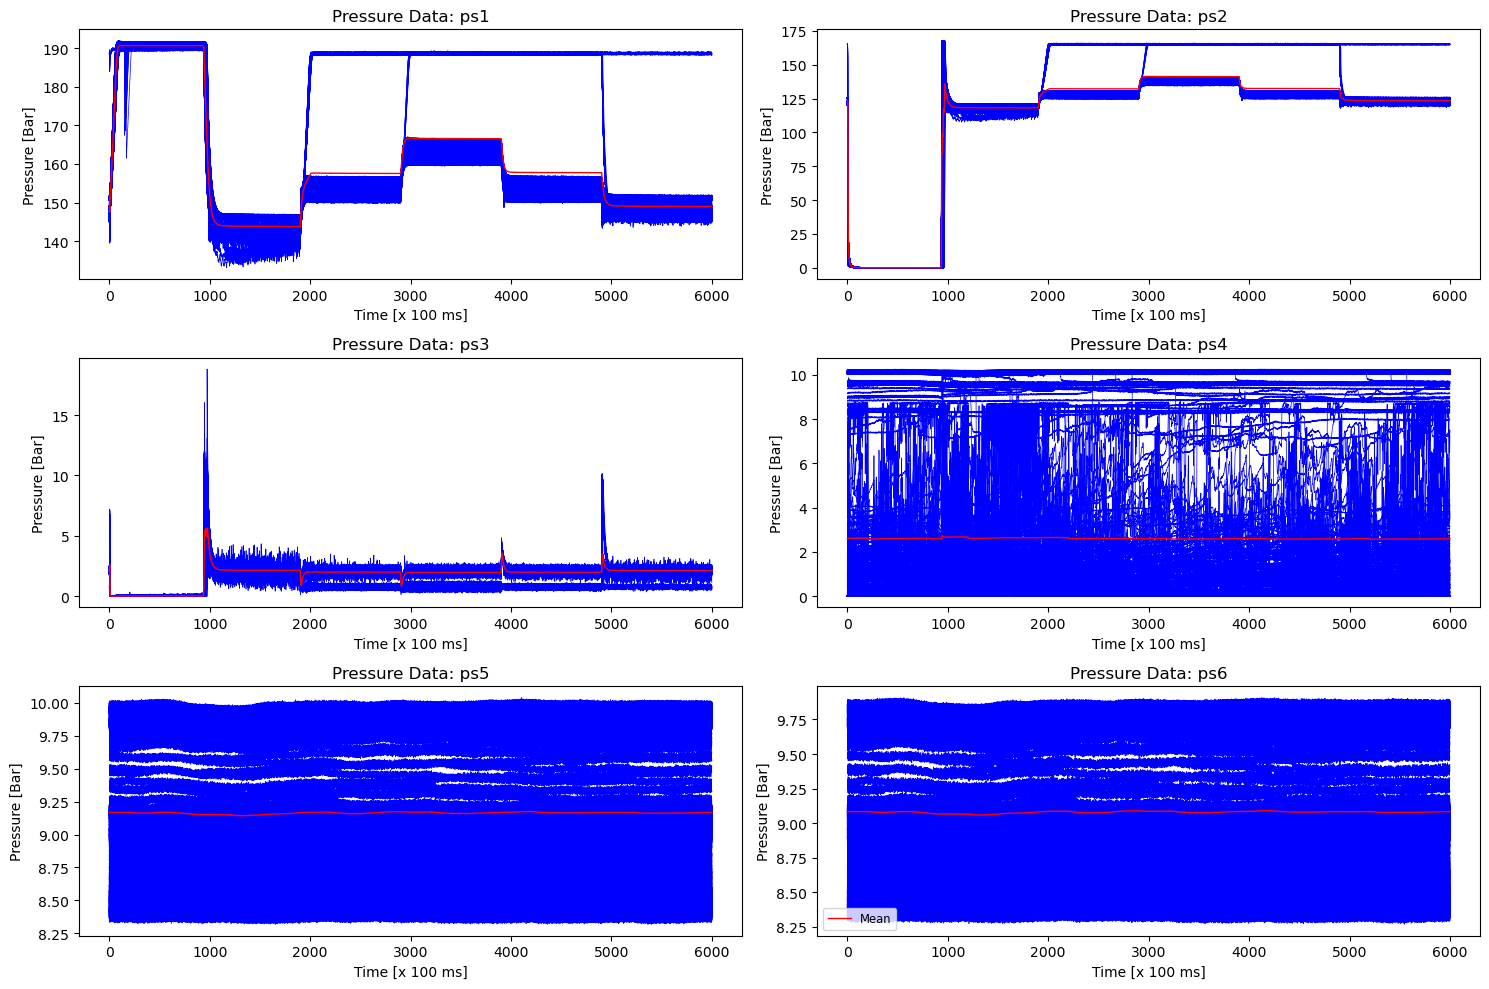

In [88]:
ps_sensors = ['ps1', 'ps2', 'ps3', 'ps4', 'ps5', 'ps6']

fig, axes = plt.subplots(3, 2, figsize=(15, 10), dpi=100)
axes = axes.flatten()

for idx, s in enumerate(ps_sensors):
    ax = axes[idx]
    
    # Nur jede 10. Spalte auswählen
    # reduced_data = data[s].iloc[:, ::10]
    
    for i in range(data[s].shape[0] - 1):
        ax.plot(data[s].iloc[i], color='blue', linewidth=0.5)
    
    ax.plot(data[s].mean(axis=0), color='red', linewidth=1, label = 'Mean')
    
    ax.set_title(f"Pressure Data: {s}")
    ax.set_xlabel("Time [x 100 ms]")
    ax.set_ylabel("Pressure [Bar]")
    
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()


In [66]:
for s in ps_sensors:
    df_combined = pd.concat([data[s], df_target], axis=1)
    mean_per_condition = (
        df_combined.drop(columns=['Valve_Condition'], axis=1) 
          .groupby(df_combined['Valve_Condition'])           
          .mean()                                
          .mean(axis=1)
        )
    print(s + ':')                             
    print(mean_per_condition)

ps1:
Valve_Condition
73     161.408184
80     161.211482
90     161.239718
100    159.716214
dtype: float64
ps2:
Valve_Condition
73     109.810641
80     109.957396
90     110.273762
100    108.771240
dtype: float64
ps3:
Valve_Condition
73     1.702893
80     1.708117
90     1.710377
100    1.797482
dtype: float64
ps4:
Valve_Condition
73     3.422267
80     3.214646
90     3.248737
100    1.933113
dtype: float64
ps5:
Valve_Condition
73     9.150767
80     9.149400
90     9.148484
100    9.176539
dtype: float64
ps6:
Valve_Condition
73     9.067561
80     9.065915
90     9.065221
100    9.091968
dtype: float64


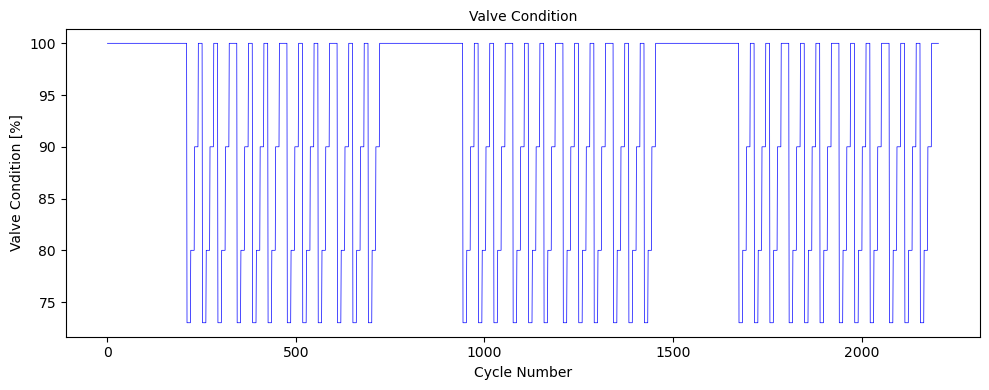

In [79]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

ax.plot(df_target, color='blue', linewidth=0.5)

ax.set_title('Valve Condition', fontsize=10)
plt.xlabel("Cycle Number")
plt.ylabel("Valve Condition [%]")

plt.tight_layout()
plt.show()

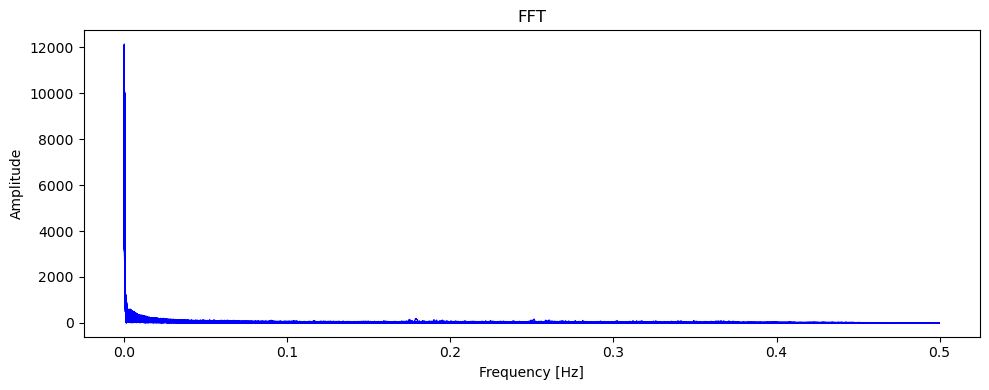

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Angenommene Sampling-Rate (diese muss an deine tatsächlichen Daten angepasst werden)
sampling_rate = 1  # Beispiel: 1 Hz Sampling-Rate, anpassen, falls notwendig

# Erstelle das Plot für die FFTs aller Serien
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

# Berechne und plotte die FFT für jede Zeitreihe
for i in range(data['ps3'].shape[0]):
    time_series = data['ps3'].iloc[i].values
    fft_values = np.fft.fft(time_series)
    frequencies = np.fft.fftfreq(len(time_series), d=sampling_rate)
    
    # Nur den positiven Frequenzbereich behalten
    positive_frequencies = frequencies[:len(frequencies) // 2]
    positive_fft_values = np.abs(fft_values[:len(fft_values) // 2])
    
    ax.plot(positive_frequencies, positive_fft_values, color = 'blue', linewidth=0.8)

# Einstellungen für das Plot
ax.set_title('FFT', fontsize=12)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


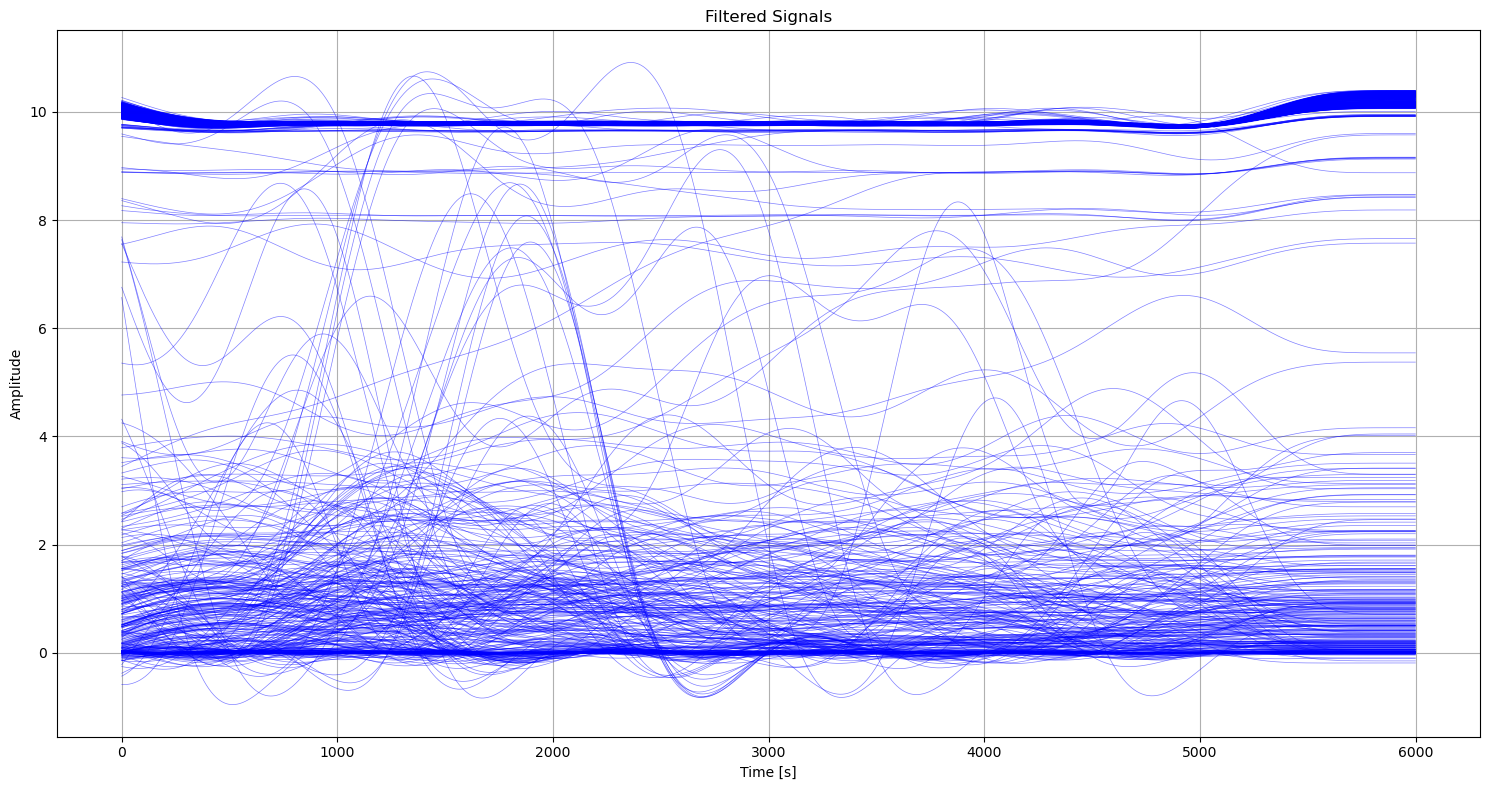

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Define the Butterworth lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    return signal.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Parameters for the filter
order = 6        # Filter order
fs = 100         # Sampling frequency (Hz)
cutoff = 0.1     # Cutoff frequency (Hz)


# Apply Butterworth filter to each row
filtered_data = data['ps4'].apply(lambda row: butter_lowpass_filter(row, cutoff, fs, order), axis=1)

# Plot all filtered signals in one graph
plt.figure(figsize=(15, 8))

for idx in range(filtered_data.shape[0]):
    plt.plot(filtered_data.iloc[idx], color = 'blue', alpha=0.5, linewidth=0.5)  # Adjust alpha and linewidth for better visualization

plt.title('Filtered Signals')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()
